(P||(P+Q)/2 + Q||(P+Q)/2)/2

In [1]:
from numpy.linalg import norm
import random as ran
import numpy as np
from math import log
from scipy.linalg import eig 

def find_stationary(transition_matrix):
    S, U = eig(transition_matrix.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    return np.abs(stationary)


def kl_distance(P, Q):
    total_distance = 0
    for i in range(len(P)):
        if Q[i] == 0 or P[i] == 0:
            continue
        total_distance += P[i] * log(P[i]/Q[i])
            
    return total_distance

"""def kl_distance2(P, Q):
    total_distance = 0
    for i in range(len(P)):
        if P[i] == 0:
            continue
        total_distance += P[i] * log(P[i]/((Q[i] + P[i])/2))
    return total_distance"""

def kl_distance2(P, Q):
    total_distance = 0
    for i in range(len(P)):
        if P[i] == 0:
            continue
        total_distance += P[i] * log(P[i]/Q[i])
    return total_distance

def solveStationary(A):
    """ x = xA where x is the answer
    x - xA = 0
    x( I - A ) = 0 and sum(x) = 1
    """
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.matrix( [0] * n + [ 1 ] ).T
    return np.squeeze(np.asarray(np.linalg.lstsq( a, b )[0]))

def distance(A1, A2):
    stationary = solveStationary(A1)
    return sum([stationary[i] * (2*kl_distance2(A1[i], A2[i])) for i in range(len(stationary))])
    #return sum([(2*kl_distance2(A1[i], A2[i])) for i in range(len(stationary))])

def hmm_distance(A1, A2):
    return (distance(A1, A2) + distance(A2, A1)) / 2

class kMeans:
    def __init__(self, em, n_clusters=3, initial_centers=None, n_iters=20, n_runs=10):
        self.em = em
        self.initial_centers = initial_centers
        self.n_clusters = n_clusters
        self.n_iters = n_iters
        self.n_runs = n_runs
        
    def _transition_matrices_for_cluster(self, k, assignments):
        members = [key for key, value in assignments.items() if value == k]

        matrices = []
        for host in members:
            matrices.append(self.em.hosts[host]['transition_matrix'])

        return np.array(matrices)

    def _compute_centroids(self, assignments):
        C = np.zeros(shape=(self.n_clusters, self.em.m, self.em.m), dtype='d')
        
        for k in range(self.n_clusters):

            if not (np.array(list(assignments.values())) == k).any():
                continue
                
            matrices = self._transition_matrices_for_cluster(k, assignments)
            C[k] = np.mean(matrices, axis=0)
        return C

    def _cost(self, C, assignments):
        cost = 0
        for k in range(self.n_clusters):
            matrices = self._transition_matrices_for_cluster(k, assignments)
            for transition_matrix in matrices:
                cost += hmm_distance(transition_matrix, C[k])
        return cost
        
    def run(self):
        min_cost = float('+inf')
        best_C = None
        best_assignment = None
        
        for _ in range(self.n_runs):
            print('Starting run')
            # random initialize the assignment of each host to a cluster
            assignments = dict(zip(onlineEM.hosts, np.random.randint(0, self.n_clusters, len(onlineEM.hosts))))
            
            C = self._compute_centroids(assignments)
            
            C, assignments = self._base_kmeans(C)
            clust_cost = self._cost(C, assignments)

            if clust_cost < min_cost:
                min_cost = clust_cost
                best_C = C.copy()
                best_assignment = assignments.copy()
            
        self.assignments = best_assignment
        self.centers = best_C   
        return best_C, best_assignment


    def _base_kmeans(self, C):
        n = len(self.em.hosts)

        C_final = C

        #KMeans algorithm
        cent_dists = None
        assignments = None
        prev_assignments = None
        best_shift = None

        iters = self.n_iters
        converged = False

        while iters != 0 and not converged:
            #assign elements to new clusters    
            assignments = {}
            for host in self.em.hosts:
                distances = np.array([hmm_distance(self.em.hosts[host]['transition_matrix'], C_final[i]) 
                                      for i in range(self.n_clusters)])
                assignments[host] = np.argmin(distances)

            #check if converged, if not compute new centroids
            if prev_assignments is not None and prev_assignments == assignments:
                converged = True
                print('converged')
            else: 
                C_final = self._compute_centroids(assignments)
                print('The cost is', self._cost(C_final, assignments))

            prev_assignments = assignments
            iters -= 1

        return C_final, assignments
                
    def classify(self, data_point):
        return min(range(self.n_clusters), key=lambda p: hmm_distance(data_point, self.centers[p]))

In [20]:
from sklearn.externals import joblib

onlineEM = joblib.load('onlineEM_15_days_7_alligned.pkl')
#groupped_data = joblib.load('groupped_data_60_1_1500.pkl')
groupped_data1 = joblib.load('groupped_data_15_days_17281_21600.pkl')

In [ ]:
from plots import plot_points
%matplotlib inline

plot_points(groupped_data.values[:,:2], em=onlineEM)

Should this be done?

In [3]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for l in  tm:
        l[l==0] = 0.00001

Or this?

In [92]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, point in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        if point == 0:
            tm[i] = np.zeros(onlineEM.m)

In [21]:
# Percentage of staying in the same state
total = 0
same = 0
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    points_per_cluster = onlineEM.hosts[host]['points_per_cluster']
    total += sum(points_per_cluster)
    i = 0
    for p, tvector in zip(points_per_cluster, tm):
        same += tm[i][i] * p
        i += 1

    
print('Stay in same state' , same / total * 100, '%')

Stay in same state 70.4634250851 %


Initialize hmm 

In [22]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [23]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

TESTING

In [6]:
kmeans = kMeans(onlineEM, n_clusters=10, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 952.55229675
The cost is 682.612678583
The cost is 656.051379782
The cost is 645.431610036
The cost is 633.429566128
The cost is 625.177282232
The cost is 622.82592028
The cost is 623.136948011
The cost is 626.532941088
The cost is 631.312481705
The cost is 619.065326357
The cost is 612.206650954
The cost is 610.837086234
The cost is 610.428498335
The cost is 610.368187336
Starting run
The cost is 881.138112589
The cost is 727.443204998
The cost is 706.838061915
The cost is 651.125491605
The cost is 615.990737765
The cost is 604.283275909
The cost is 596.344074602
The cost is 583.727613809
The cost is 577.573537021
The cost is 577.357659156
The cost is 575.343910273
The cost is 576.731005619
The cost is 575.768492829
The cost is 576.634479365
The cost is 577.305511306
Starting run
The cost is 833.42109613
The cost is 621.372421608
The cost is 583.463751523
The cost is 572.524163895
The cost is 564.617176868
The cost is 543.358958559
The cost is 529.150632111
Th

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


The cost is 757.756287943
The cost is 742.829860526
The cost is 721.772831201
The cost is 692.468382554
The cost is 686.162170914
The cost is 671.930366502
The cost is 656.631647596
The cost is 645.601068181
The cost is 640.426728187
The cost is 637.496363916
The cost is 635.494654856
The cost is 634.200443316
The cost is 634.243913936
The cost is 632.95607723
Starting run
The cost is 927.75785322
The cost is 719.903497949
The cost is 685.89373174
The cost is 678.093942027
The cost is 677.346108135
The cost is 675.969582215
The cost is 669.64258769
The cost is 663.221086352
The cost is 657.590713773
The cost is 655.174878216
The cost is 654.785767216
The cost is 654.263288026
The cost is 653.285819449
The cost is 649.423554983
The cost is 646.21298066
Starting run
The cost is 825.47749852
The cost is 610.825882286
The cost is 584.235937178
The cost is 564.294899639
The cost is 549.10294894
The cost is 539.378367983
The cost is 532.364172427
The cost is 528.85205029
The cost is 527.0548

In [18]:
num_hosts = 2268

print(calculate_likelihood_em(groupped_data1.values[:,[0,1,3]], kmeans, take_mean=False))

print(calculate_likelihood_em(groupped_data1.values[:,[0,1,3]], kmeans, take_mean=True, weight=0.2))

10000 -1.298335558950813
20000 -1.297881695452225
30000 -1.3397293703352156
40000 -1.3308790562646728
50000 -1.3132504377440255
60000 -1.329265087946072
70000 -1.330170018330559
80000 -1.317268321513228
90000 -1.3260275303573548
100000 -1.3387926572600046
110000 -1.3403749598627734
120000 -1.3393267440834364
130000 -1.3495616734671452
140000 -1.3499193572825952
150000 -1.3448313683628927
160000 -1.3460533518211673
170000 -1.3474003920574598
180000 -1.342071478074698
190000 -1.3392198113320837
200000 -1.3421378184628352
210000 -1.3397820419454936
220000 -1.3337777245137528
230000 -1.3379596971045011
240000 -1.341105923522096
250000 -1.3408334292924367
260000 -1.3422537179609577
270000 -1.3445074778621462
280000 -1.3434539465117914
290000 -1.3413866250073245
300000 -1.3431996712007468
310000 -1.3421798177647988
320000 -1.3395645438199615
330000 -1.3400082691617585
340000 -1.3417379451097056
350000 -1.339405320098979
360000 -1.3376786593933687
370000 -1.3402036614621045
380000 -1.34139959

3010000 -1.6395373988025497
3020000 -1.6392583799495435
3030000 -1.639007098947384
3040000 -1.6382409875722503
3050000 -1.637949652686102
3060000 -1.6376625169634453
3070000 -1.6372295202870852
3080000 -1.6365568989567407
3090000 -1.6362357973549873
3100000 -1.6360682395972463
3110000 -1.6354965214153432
3120000 -1.6352298143073747
3130000 -1.6350777140896995
3140000 -1.6344989126197773
3150000 -1.6340509889312997
3160000 -1.633671208513427
3170000 -1.6333085875953894
3180000 -1.632685445060139
3190000 -1.6323692618360266
3200000 -1.6321794776540728
3210000 -1.6314416607288982
3220000 -1.63115404947371
3230000 -1.6312795191622032
3240000 -1.6312803983229462
3250000 -1.6309143691542989
3260000 -1.6306691392225596
3270000 -1.6305626297192874
3280000 -1.6297991847452757
3290000 -1.6294397599026433
3300000 -1.629160496644413
3310000 -1.628634132985221
3320000 -1.6281477819841195
3330000 -1.6278437249137447
3340000 -1.6275638955028289
3350000 -1.6267250615572315
3360000 -1.6264613916157098


5970000 -1.6569366039890752
5980000 -1.6564290536529542
5990000 -1.6559861992497529
6000000 -1.6556282053699178
6010000 -1.6550396430269396
6020000 -1.6545873231442556
6030000 -1.6541811091135314
6040000 -1.6536045633035719
6050000 -1.653093849115241
6060000 -1.652745409421597
6070000 -1.652192036893883
6080000 -1.65160630043235
6090000 -1.6512063007245072
6100000 -1.650864008872456
6110000 -1.6503747045738948
6120000 -1.6503621387323406
6130000 -1.6505486983402953
6140000 -1.6505596855904048
6150000 -1.6501304353744841
6160000 -1.6498823736314174
6170000 -1.6494929634005648
6180000 -1.648849606971139
6190000 -1.6484284957040327
6200000 -1.6480411299194218
6210000 -1.6474293884043962
6220000 -1.6468550999709046
6230000 -1.6465647568291937
6240000 -1.646165953568954
6250000 -1.6455981151857537
6260000 -1.645255233429959
6270000 -1.6449350450796816
6280000 -1.6443677934704983
6290000 -1.6438288590153187
6300000 -1.6434007627723348
6310000 -1.6429033483369946
6320000 -1.6422635419084763
6

8930000 -1.6136174523292577
8940000 -1.6128298879781637
8950000 -1.612018448456967
8960000 -1.611099526843547
8970000 -1.6100838772857673
8980000 -1.6090891606421103
8990000 -1.6080799149592182
9000000 -1.6070922010688116
9010000 -1.6060919003284169
9020000 -1.6051248382889567
9030000 -1.6041434606367968
9040000 -1.6031638005107047
9050000 -1.602173014726517
9060000 -1.601182892282813
9070000 -1.6002059670079058
9080000 -1.5992456914018038
9090000 -1.5982699900957609
9100000 -1.5973143198019422
9110000 -1.596324192982921
9120000 -1.595379256581923
9130000 -1.5943981650688976
9140000 -1.5934426404894437
9150000 -1.5924931653249563
9160000 -1.591527276441855
9170000 -1.5905622619207025
9180000 -1.5895908220297188
9190000 -1.5886160407625773
9200000 -1.5876384237706143
9210000 -1.586684559163989
9220000 -1.585744606701672
9230000 -1.5848033111937658
9240000 -1.5838297876875729
9250000 -1.582856706641459
9260000 -1.5818910491618274
9270000 -1.580914150560393
9280000 -1.5799579791309424
929

2130000 -1.5791127413134924
2140000 -1.5808828799373225
2150000 -1.5827726434090756
2160000 -1.583814946013877
2170000 -1.5848164762845984
2180000 -1.5859685432358022
2190000 -1.5866653514914706
2200000 -1.5871600406327124
2210000 -1.5879435600201037
2220000 -1.5884553488443365
2230000 -1.5885410753369535
2240000 -1.58910485057531
2250000 -1.5895374001809879
2260000 -1.589627973333767
2270000 -1.5897050352074038
2280000 -1.5902376885886662
2290000 -1.590501245431314
2300000 -1.5904798639571889
2310000 -1.5909072408752478
2320000 -1.5910585721966224
2330000 -1.5908788801790303
2340000 -1.5907867287423234
2350000 -1.5909354992395561
2360000 -1.5906691958271415
2370000 -1.5903269326218283
2380000 -1.5904712720279466
2390000 -1.5901779827130187
2400000 -1.5896187559895405
2410000 -1.5893151232409863
2420000 -1.589267286049093
2430000 -1.5890155473166907
2440000 -1.5886534046083034
2450000 -1.5886807754017331
2460000 -1.588428521985521
2470000 -1.5879387642627407
2480000 -1.5877374016635932

5090000 -1.596370765393205
5100000 -1.5970859697263817
5110000 -1.597813776909741
5120000 -1.5982717553683041
5130000 -1.5988780973769021
5140000 -1.5994951231386838
5150000 -1.6001093862412281
5160000 -1.600541520954919
5170000 -1.6012042069182484
5180000 -1.6018077877916461
5190000 -1.6022358467311195
5200000 -1.6028108565595167
5210000 -1.603398523526414
5220000 -1.6038155554851035
5230000 -1.6042789594365618
5240000 -1.6048390792238754
5250000 -1.605432670075975
5260000 -1.6058065928431582
5270000 -1.6063223241712894
5280000 -1.6069915169259252
5290000 -1.6074297576254442
5300000 -1.6079791187433772
5310000 -1.6085461389325573
5320000 -1.6090258171490068
5330000 -1.6093629939931342
5340000 -1.6098301873797047
5350000 -1.6101965288195648
5360000 -1.6101599004014857
5370000 -1.6103426270706902
5380000 -1.6104936980852291
5390000 -1.610539978231784
5400000 -1.6106020667663439
5410000 -1.6110361291457425
5420000 -1.6111743933973235
5430000 -1.611098887334101
5440000 -1.6111933729938375

8050000 -1.5519135120442014
8060000 -1.5519645426766822
8070000 -1.5520989049827063
8080000 -1.5522135143862252
8090000 -1.552359256997686
8100000 -1.5524412087373083
8110000 -1.5525213661944846
8120000 -1.5526004418950454
8130000 -1.552704211956962
8140000 -1.5528557636504314
8150000 -1.552992654425438
8160000 -1.5531561315042894
8170000 -1.5532823698906577
8180000 -1.553422218318721
8190000 -1.5535544509652321
8200000 -1.553747347538591
8210000 -1.5539482341679904
8220000 -1.5540969555037583
8230000 -1.5542658162141971
8240000 -1.554447243789395
8250000 -1.554656568343749
8260000 -1.5547996424114041
8270000 -1.5549914070908792
8280000 -1.5551763422798632
8290000 -1.5553716932814636
8300000 -1.5556411667298202
8310000 -1.5558763035407892
8320000 -1.5561000231470103
8330000 -1.5562826308947477
8340000 -1.55648500416034
8350000 -1.5566873605927989
8360000 -1.556836639443604
8370000 -1.5569986422478952
8380000 -1.5571738795382808
8390000 -1.5573290946188132
8400000 -1.5575011415321278
84

In [16]:
print(calculate_likelihood_em(groupped_data1.values[:num_hosts*100,[0,1,3]], kmeans, take_mean=False))

10000 -1.298335558950813
20000 -1.297881695452225
30000 -1.3397293703352156
40000 -1.3308790562646728
50000 -1.3132504377440255
60000 -1.329265087946072
70000 -1.330170018330559
80000 -1.317268321513228
90000 -1.3260275303573548
100000 -1.3387926572600046
110000 -1.3403749598627734
120000 -1.3393267440834364
130000 -1.3495616734671452
140000 -1.3499193572825952
150000 -1.3448313683628927
160000 -1.3460533518211673
170000 -1.3474003920574598
180000 -1.342071478074698
190000 -1.3392198113320837
200000 -1.3421378184628352
210000 -1.3397820419454936
220000 -1.3337777245137528
-1.3372509575980982


In [17]:
for weight in np.arange(0.01,0.5, 0.01):
    print(weight)

    print(calculate_likelihood_em(groupped_data1.values[:num_hosts*100,[0,1,3]], kmeans, take_mean=True, weight=weight))

0.01
10000 -1.226940332838744
20000 -1.2260015948499052
30000 -1.2675566426003877
40000 -1.257527525313402
50000 -1.2400356385039037
60000 -1.2561462584617316
70000 -1.257041319911723
80000 -1.2446996876619014
90000 -1.2524154627573543
100000 -1.2646860100657702
110000 -1.265984388091651
120000 -1.26513803066782
130000 -1.275355546044544
140000 -1.2757537446663194
150000 -1.2709168370453425
160000 -1.2722913944616694
170000 -1.273772462095189
180000 -1.2685979369791611
190000 -1.26576132531969
200000 -1.2688139314069768
210000 -1.2664527528450136
220000 -1.2605804665866533
-1.2637875339559217
0.02
10000 -1.2272802200488948
20000 -1.2263717209574752
30000 -1.2679257717445604
40000 -1.2579072506808515
50000 -1.2404058698165763
60000 -1.2565134791800026
70000 -1.2574089041772603
80000 -1.2450660461489782
90000 -1.2527907049484683
100000 -1.2650636718970598
110000 -1.2663617705638266
120000 -1.2655125159858458
130000 -1.275730059047688
140000 -1.276127232767645
150000 -1.271286887742807
16

KeyboardInterrupt: 

In [ ]:
num_hosts = int(len(set(groupped_data['source computer'].values)))

calculate_likelihood_em(groupped_data1.values[:num_hosts*100,[0,1,3]], kmeans, take_mean=True, weight=1)

In [7]:
from math import log
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

def calculate_likelihood_em(data, kmeans, take_mean=False, weight=0.5):
    # first reset previous point for all hosts for rerun

    previous_points = {}
    for host in onlineEM.hosts:
        previous_points[host] = onlineEM.hosts[host]['hard_previous']

    total_likelihood = []
    
    i = 0
    for point in data:
        i += 1
        if i % 10000 == 0:
            print(i, sum(total_likelihood) / len(total_likelihood))
            
        host = point[-1]

        previous_point = previous_points[host]

        point_center = onlineEM.closest_centers([point])
        closest_center = np.argmax(point_center)

        previous_points[host] = closest_center
        
        if take_mean:
            kmeans_probabilities = kmeans.centers[kmeans.assignments[host]][previous_point]
            host_probabilities = onlineEM.hosts[host]['transition_matrix'][previous_point]
            probabilities = kmeans_probabilities * weight + host_probabilities * (1 - weight)
        else:
            probabilities = kmeans.centers[kmeans.assignments[host]][previous_point]
    
        participation = probabilities * np.array([poisson(point, lambda_i) for lambda_i in onlineEM.lambdas])
        
        likelihood = log(np.sum(participation))
    
        total_likelihood.append(likelihood)

    return sum(total_likelihood) / len(total_likelihood)

In [ ]:
kmeans_all = []
for n_clusters in range(1, 10):
    print('Starting for', n_clusters)
    kmeans = kMeans(onlineEM, n_clusters=n_clusters, initial_centers=None, n_iters=15, n_runs=5)
    C, assign = kmeans.run()
    kmeans_all.append(kmeans)

Starting for 1
Starting run
The cost is 2294.80440892
converged
Starting run
The cost is 2294.80440892
converged
Starting run
The cost is 2294.80440892
converged
Starting run
The cost is 2294.80440892
converged
Starting run
The cost is 2294.80440892
converged
Starting for 2
Starting run
The cost is 1541.67330864
The cost is 1300.98216723
The cost is 1292.02198478
The cost is 1287.00241338
The cost is 1284.91362311
The cost is 1283.22085801
The cost is 1281.25187118
converged
Starting run
The cost is 1318.63596619
The cost is 1246.57244993
The cost is 1251.73667706
The cost is 1263.40365149
The cost is 1272.2372349
The cost is 1277.66464029
The cost is 1281.05842702
converged
Starting run
The cost is 1334.99129692
The cost is 1257.38474522
The cost is 1267.00833327
The cost is 1273.26938668
The cost is 1278.38888368
The cost is 1281.05842702
converged
Starting run
The cost is 1776.75232423
The cost is 1286.00847734
The cost is 1246.59877904
The cost is 1258.26612915
The cost is 1269.034

The cost is 808.377564518
The cost is 806.513002677
The cost is 804.187942257
The cost is 802.672289712
The cost is 800.021518769
Starting run
The cost is 1023.82190209
The cost is 857.996505763
The cost is 833.628091508
The cost is 830.43946436
The cost is 806.040345693
The cost is 786.30894027
The cost is 773.873230169
The cost is 772.090897227
The cost is 777.780086036
The cost is 781.34105935
The cost is 784.892650005
The cost is 786.839132005
The cost is 788.5380198
The cost is 788.627608164
The cost is 791.583461511
Starting for 7
Starting run
The cost is 1081.3437226
The cost is 883.268447118
The cost is 753.235257318
The cost is 706.107621949
The cost is 699.318442804
The cost is 704.339828432
The cost is 706.065467567
The cost is 707.283052444
The cost is 707.736317349
The cost is 709.248682822
The cost is 715.271837431
The cost is 716.885374315
The cost is 719.965389814
The cost is 724.509006318
The cost is 728.010201447
Starting run
The cost is 925.60815553
The cost is 854.4

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


The cost is 806.197467938
The cost is 761.638785077
The cost is 702.570967269
The cost is 687.460630298
The cost is 683.814836577
The cost is 681.132040717
The cost is 686.477313318
The cost is 692.495437821
The cost is 691.957377383
The cost is 670.655166168
The cost is 663.691726815
The cost is 666.302768434
The cost is 671.152279733
The cost is 676.070937213
Starting run
The cost is 1037.78486483
The cost is 813.367014404
The cost is 719.274122581
The cost is 705.481475644
The cost is 693.123169916
The cost is 692.775413998
The cost is 691.632212718
The cost is 696.543681298
The cost is 699.271806179
The cost is 700.948423213
The cost is 705.930364619
The cost is 709.085117419
The cost is 708.372491257
The cost is 707.781461659
The cost is 706.906158178
Starting run
The cost is 930.571248624
The cost is 752.311828923
The cost is 704.629061654
The cost is 688.667940729
The cost is 682.745025438
The cost is 677.549366099
The cost is 676.34964526
The cost is 675.450196557
The cost is 6

In [ ]:
for n_clusters in [10, 15, 25, 50, 100]:
    print('Starting for', n_clusters)
    kmeans = kMeans(onlineEM, n_clusters=n_clusters, initial_centers=None, n_iters=15, n_runs=5)
    C, assign = kmeans.run()
    kmeans_all.append(kmeans)

In [ ]:
joblib.dump(kmeans_all, 'kmeans_all_15_days_P_div_Q_n_clusters.pkl')

# kmeans_all = joblib.load('kmeans_all_500_1_to_8_clusters__hmm_distance.pkl')

In [ ]:
for kmeans in kmeans_all:
    print('For number of clusters', kmeans.n_clusters)
    print(calculate_likelihood_em(groupped_data1.values[:189400,[0,1,3]], kmeans, take_mean=False))

In [17]:
for kmeans in kmeans_all:
    print('For number of clusters', kmeans.n_clusters)
    print(calculate_likelihood_em(groupped_data1.values[:189400,[0,1,3]], kmeans, take_mean=True, weight=0.5))

For number of clusters 1
10000 -3.620677222455439
20000 -3.6838785162212107
30000 -3.7062074132723066
40000 -3.7234737331151706
50000 -3.775355560476942
60000 -3.7773153464093827
70000 -3.777064351710199
80000 -3.7876366572709945
90000 -3.7854355778202593
100000 -3.7745135274657646
110000 -3.778547740907677
120000 -3.7685553359603796
130000 -3.758453519618155
140000 -3.757946088835174
150000 -3.7532973582796743
160000 -3.750568073675632
170000 -3.754177264203289
180000 -3.755827562018364
-3.7566040137456946
For number of clusters 2
10000 -3.6106902511159875
20000 -3.6756207035175197
30000 -3.6977329693475545
40000 -3.7159255523838195
50000 -3.7699149089882935
60000 -3.7737173205672523
70000 -3.774120714731806
80000 -3.7853276686286716
90000 -3.783343042271286
100000 -3.7725489650811594
110000 -3.7767318593161847
120000 -3.7666382266819425
130000 -3.7563840685985865
140000 -3.75588187140704
150000 -3.751271403296186
160000 -3.7485455149498206
170000 -3.7525999016886455
180000 -3.7544509

KeyboardInterrupt: 

In [17]:
kmeans_score = []
for n_clusters in range(1, 20):
    print('======================================================================')
    print('n_clusters', n_clusters)
    kmeans = kMeans(onlineEM, n_clusters=n_clusters, initial_centers=None, n_iters=10, n_runs=5)
    C, assign = kmeans.run()
    
    inertia = kmeans._cost(C, assign)
    print('inertia', inertia)
    
    kmeans_score.append((n_clusters, inertia))

n_clusters 1
Starting run
The cost is 436.601776815
converged
Starting run
The cost is 436.601776815
converged
Starting run
The cost is 436.601776815
converged
Starting run
The cost is 436.601776815
converged
Starting run
The cost is 436.601776815
converged
inertia 436.601776815
n_clusters 2
Starting run
The cost is 352.104699033
The cost is 326.932616313
The cost is 314.642706353
The cost is 310.876359567
The cost is 310.613914418
The cost is 310.621411071
converged
Starting run
The cost is 401.621419772
The cost is 396.786692909
The cost is 389.720449474
The cost is 382.801796525
The cost is 377.135250613
The cost is 375.353449037
The cost is 375.624650841
The cost is 375.945598396
converged
Starting run
The cost is 328.280230965
The cost is 313.644032112
The cost is 310.723167909
The cost is 310.626503462
The cost is 310.621411071
converged
Starting run
The cost is 357.032228041
The cost is 348.99561559
The cost is 321.791967321
The cost is 310.653996436
The cost is 310.622746994
Th

The cost is 209.80192352
The cost is 199.236157146
The cost is 195.720675305
The cost is 194.842161422
The cost is 194.457515842
The cost is 194.229859765
converged
inertia 194.229859765
n_clusters 8
Starting run
The cost is 241.296215469
The cost is 206.549790525
The cost is 192.242467343
The cost is 189.102187891
The cost is 188.292795205
The cost is 187.683609143
The cost is 187.350411089
The cost is 187.457476183
The cost is 187.824666176
The cost is 187.99662057
Starting run
The cost is 305.938116613
The cost is 217.199389945
The cost is 200.162105569
The cost is 195.389074886
The cost is 201.122600369
The cost is 211.07573992
The cost is 216.679192017
The cost is 219.870721554
The cost is 214.751056391
The cost is 209.977683776
Starting run
The cost is 292.949675351
The cost is 236.607709537
The cost is 237.985592215
The cost is 220.726345475
The cost is 219.057251923
The cost is 215.274484561
The cost is 213.3769312
The cost is 210.270194697
The cost is 207.458296165
The cost is

The cost is 163.430363392
The cost is 163.476548844
The cost is 169.621382634
The cost is 165.418178156
The cost is 166.050795515
The cost is 166.069410264
The cost is 165.764176532
The cost is 168.321962481
Starting run
The cost is 213.731879887
The cost is 190.821595141
The cost is 185.822747867
The cost is 183.396363227
The cost is 181.701601634
The cost is 179.746455873
The cost is 179.451076909
The cost is 180.211383689
The cost is 180.675146788
The cost is 181.070633773
Starting run
The cost is 255.061305415
The cost is 191.20224342
The cost is 190.711271035
The cost is 192.944602207
The cost is 193.902323225
The cost is 186.981969115
The cost is 183.49693343
The cost is 178.703000162
The cost is 179.840187728
The cost is 180.88088317
inertia 150.621587731
n_clusters 14
Starting run
The cost is 267.889829662
The cost is 212.87544398
The cost is 197.116214516
The cost is 186.007440737
The cost is 182.154513307
The cost is 182.074499325
The cost is 181.343996401
The cost is 183.867

The cost is 361.754841627
The cost is 209.900862082
The cost is 204.404393729
The cost is 197.825582217
The cost is 196.933677081
The cost is 183.79810467
The cost is 191.791120711
The cost is 186.168036298
The cost is 183.837669687
The cost is 183.956767856
Starting run
The cost is 302.130961487
The cost is 184.845766455
The cost is 154.058585208
The cost is 153.36749396
The cost is 153.890795861
The cost is 149.315369803
The cost is 143.424795438
The cost is 140.977291157
The cost is 138.818381263
The cost is 138.087037975
Starting run
The cost is 289.051841021
The cost is 160.99266703
The cost is 157.529077506
The cost is 153.23843585
The cost is 148.163251396
The cost is 168.225092844
The cost is 167.040578122
The cost is 147.713552378
The cost is 146.01001343
The cost is 145.410980289
Starting run
The cost is 312.404934209
The cost is 204.553436171
The cost is 167.796331684
The cost is 156.981210519
The cost is 153.336526692
The cost is 154.142428261
The cost is 156.901233473
The 

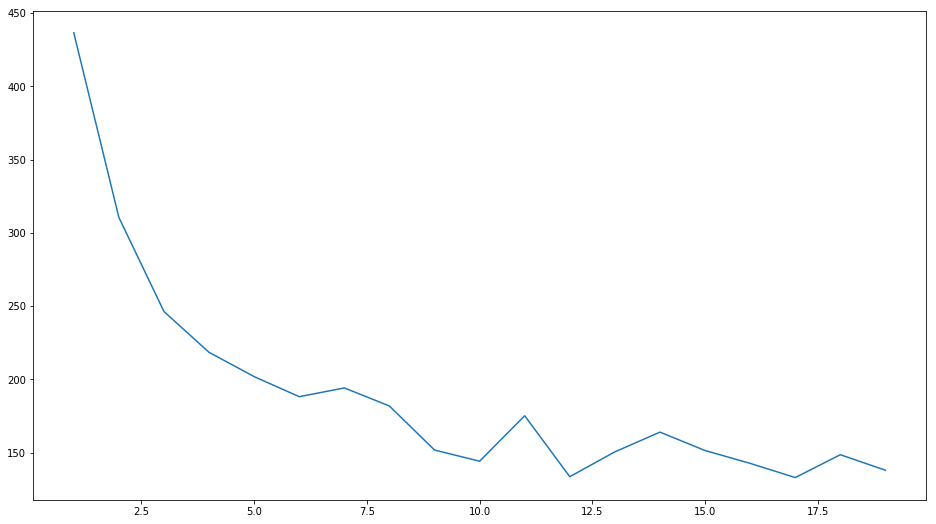

In [20]:
import matplotlib.pyplot as plt 
from pylab import rcParams

rcParams['figure.figsize'] = 16, 9


plt.plot([a for (a,b) in kmeans_score], [b for (a,b) in kmeans_score])

In [19]:
kmeans_score

[(1, 436.60177681542888),
 (2, 310.62141107100206),
 (3, 246.39587136176453),
 (4, 218.52647683215631),
 (5, 201.97232087054576),
 (6, 188.26571202698059),
 (7, 194.2298597647665),
 (8, 181.91940475939199),
 (9, 151.86289950708166),
 (10, 144.23587171043661),
 (11, 175.25836605965165),
 (12, 133.6555307187343),
 (13, 150.62158773089894),
 (14, 164.0799772667568),
 (15, 151.53319602099657),
 (16, 142.75819059706765),
 (17, 133.07462463433319),
 (18, 148.66273790290725),
 (19, 138.08703797511606)]

In [22]:
kmeans = kMeans(onlineEM, n_clusters=10, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 363.48346152
The cost is 261.061248362
The cost is 223.535364189
The cost is 217.091170183
The cost is 203.399584289
The cost is 193.921834357
The cost is 191.335957663
The cost is 186.854465018
The cost is 206.997515262
The cost is 190.92921145
The cost is 178.035481887
The cost is 176.12358994
The cost is 178.636856604
The cost is 188.739730619
The cost is 195.432525881
Starting run
The cost is 256.996223027
The cost is 238.096133182
The cost is 237.450786173
The cost is 234.066650047
The cost is 221.7146862
The cost is 225.551158958
The cost is 232.256138882
The cost is 231.391230068
The cost is 221.65170948
The cost is 211.623819006
The cost is 178.320250278
The cost is 168.679602847
The cost is 168.232557261
The cost is 168.14070865
The cost is 168.207628582
Starting run
The cost is 242.33607621
The cost is 171.128847091
The cost is 170.216554238
The cost is 161.770169324
The cost is 158.078544718
The cost is 153.77716636
The cost is 148.476157638
The cost

In [42]:
distances = []
for host in onlineEM.hosts:
    distances.append([host, hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[assign[host]])])

In [43]:
from plots import plot_points_host

In [44]:
for c in sorted(distances, key=lambda x: -x[1]):
    if c[0] == 'C5924':
        print(c[1])

0.182603901033


In [45]:
sorted(distances, key=lambda x: -x[1])[:10]

[['C4797', 3.5803113491685217],
 ['C2986', 3.223804283729339],
 ['C5089', 3.1587874687794599],
 ['C1340', 2.4671443701466269],
 ['C1823', 2.1646968530372486],
 ['C1707', 2.0255361610561957],
 ['C458', 2.014627063454649],
 ['C4299', 1.9924884403406025],
 ['C5736', 1.9748071302578327],
 ['C1685', 1.9533964543871094]]

In [ ]:
sorted(distances, key=lambda x: -x[1])[:10]

In [ ]:
distances1 = sorted(distances, key=lambda x: -x[1])

In [46]:
host = 'C4797'
plot_points_host(groupped_data.values[:, :2], hostData=groupped_data[groupped_data['source computer'] == host].values[:, :2])

NameError: name 'groupped_data' is not defined

In [58]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

import seaborn as sns


colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16
# HOST and clusters
%matplotlib inline

def plot_transition_matrix(em, kmeans, host):
    rcParams['figure.figsize'] = 16, 9

    plt.subplot(1,2,1)
    ax = sns.heatmap(em.hosts[host]['transition_matrix'])
    plt.title('Host transition matrix')
    
    plt.subplot(1,2,2)
    ax = sns.heatmap(kmeans.centers[kmeans.assignments[host]])
    plt.title('Kmeans center transition matrix for center ' + str(kmeans.assignments[host]))
    plt.show()

In [61]:
onlineEM.lambdas

array([[0.0, 0.0],
       [7.4905302576605095, 33.61984253955146],
       [36.29728398378872, 37.892052048788166],
       [55.35796116568268, 55.510613301645876],
       [9.192336417675378, 56.8149052869277],
       [19.384708222786806, 31.128404573664405],
       [7.077061184365022, 18.804214946534405],
       [7.490530257660508, 33.619842539551406]], dtype=object)

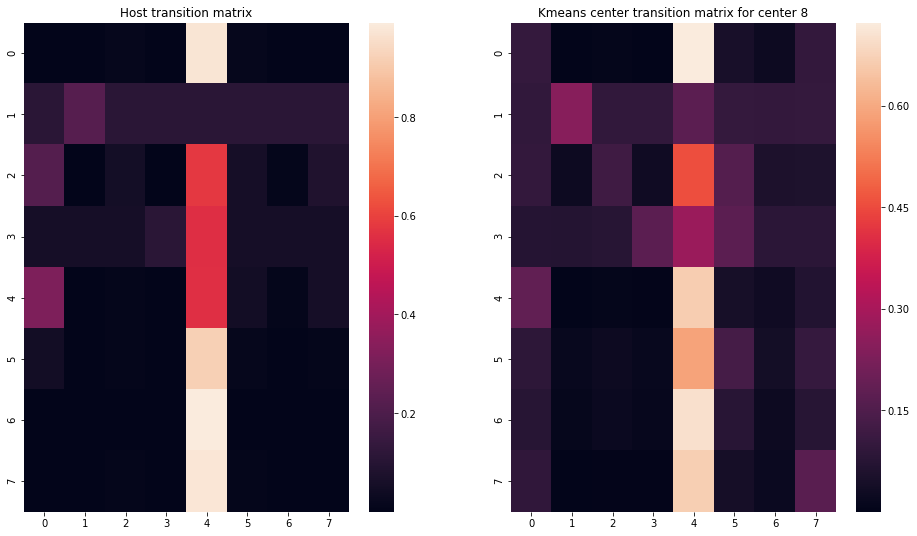

In [60]:
plot_transition_matrix(onlineEM, kmeans, host)

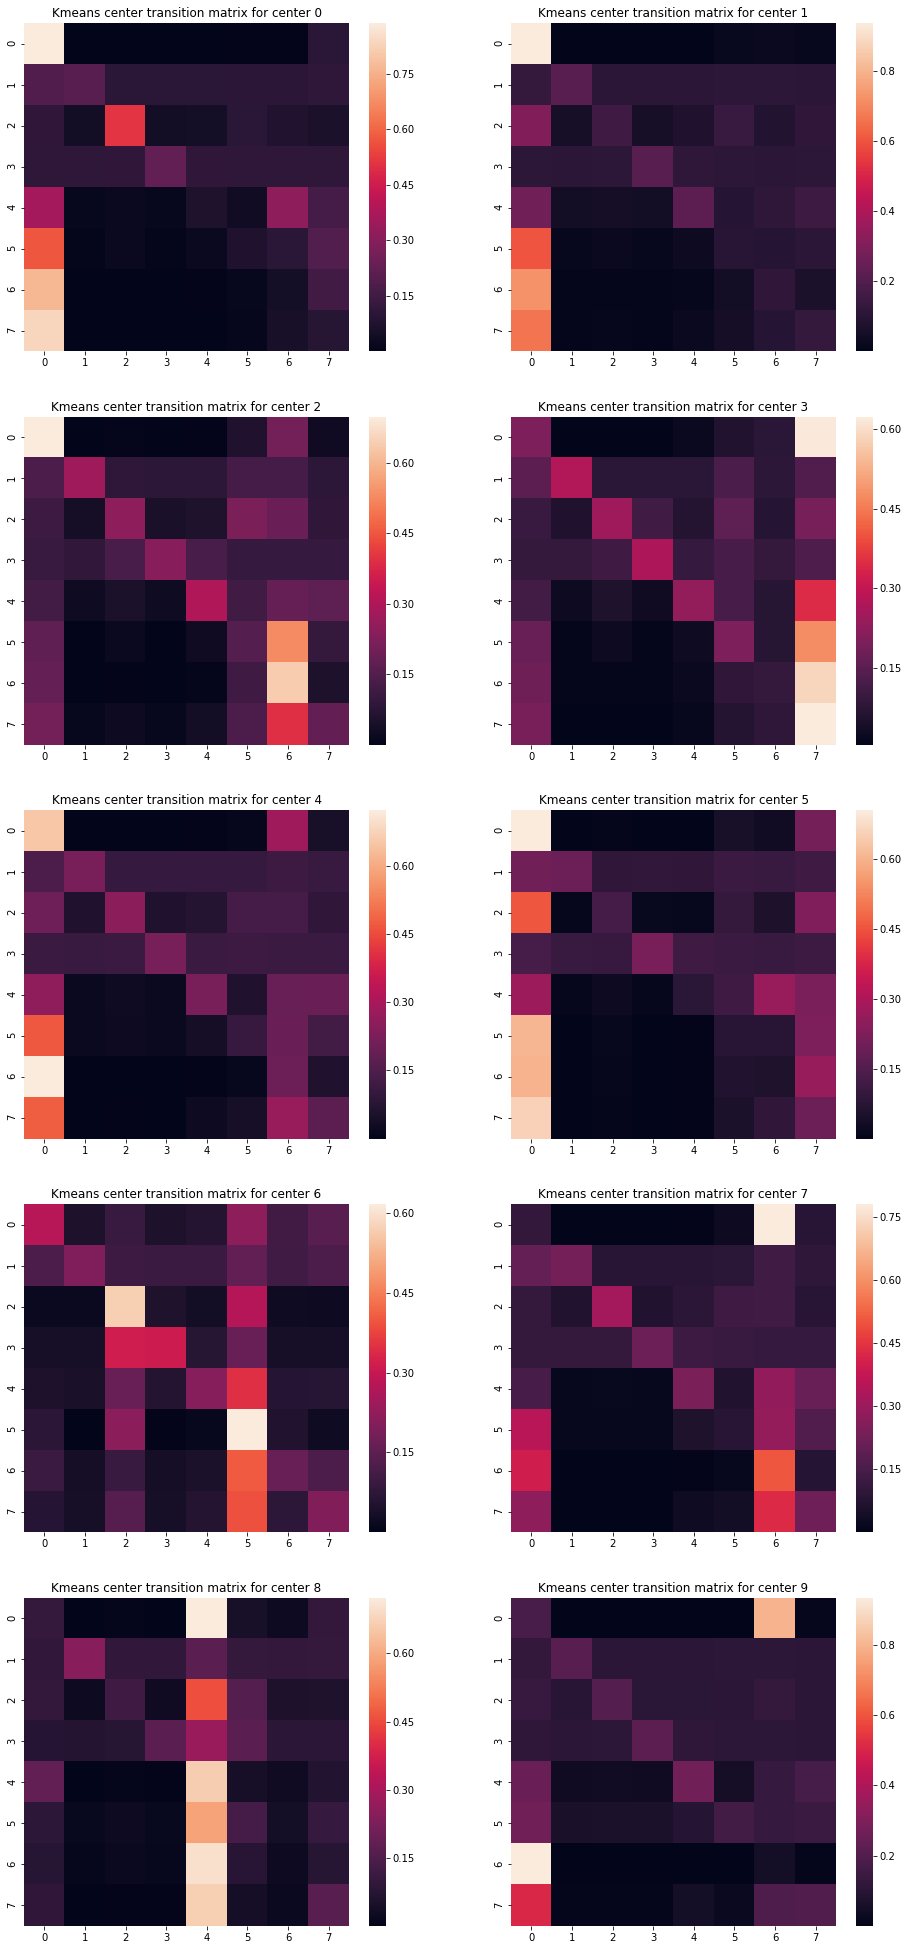

In [49]:
rcParams['figure.figsize'] = 16, 35
    
for i in range(10):
    plt.subplot(5,2,i+1)
    ax = sns.heatmap(kmeans.centers[i])
    plt.title('Kmeans center transition matrix for center ' + str(i))

plt.show()

In [50]:
import collections
    
centers = {}
for host in onlineEM.hosts:
    if kmeans.assignments[host] in centers:
        centers[kmeans.assignments[host]] += 1 
    else:
        centers[kmeans.assignments[host]] = 1


collections.OrderedDict(sorted(centers.items()))

OrderedDict([(0, 801),
             (1, 741),
             (2, 44),
             (3, 37),
             (4, 188),
             (5, 123),
             (6, 35),
             (7, 96),
             (8, 13),
             (9, 190)])

In [94]:
import random as ran
import random

random_flows = [1, 13, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
random_average_bytes = list(range(18,40))
random_average_bytes.append(1)


anomalous_host = 'A9'
epochs = 1500

data = []
for i in range(epochs):
    #flows = ran.randint(1,50)
    #average_bytes = ran.randint(1,50)
    flows = random.choice(random_flows)
    average_bytes = random.choice(random_average_bytes)
    data.append([flows, average_bytes, anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

In [95]:
distances_for_anomalous_host = []
for i in range(len(kmeans.centers)):
    distances_for_anomalous_host.append([i, hmm_distance(onlineEM.hosts[anomalous_host]['transition_matrix'], 
                                         kmeans.centers[i])])

In [96]:
distances_for_anomalous_host.sort(key=lambda x: x[1])
distances_for_anomalous_host

[[0, 0.24002655414335272],
 [2, 0.41578521657880385],
 [3, 0.59113345581969634],
 [7, 0.59652121567361371],
 [6, 0.60937371239019722],
 [5, 0.63404968452813215],
 [4, 0.64013185886856139],
 [1, 0.68044581758866007],
 [9, 0.7059348242827671],
 [8, 0.7862857931470133]]

In [5]:
kmeans_all = []
test = int(len(set(groupped_data['source computer'].values)))
for n_clusters in [10,15]:
    kmeans = kMeans(onlineEM, n_clusters=n_clusters, initial_centers=None, n_iters=15, n_runs=5)
    C, assign = kmeans.run()
    
    print('======================================================================')
    print('n_clusters weight=0.2', n_clusters)
    print(calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]], kmeans, take_mean=True, weight=0.2))
    print('======================================================================')
    print('n_clusters take_mean=False', n_clusters)
    print(calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]], kmeans, take_mean=False))
    #print(kmeans._cost(C, assign))
    kmeans_all.append(kmeans)

Starting run
The cost is 417.231481246
The cost is 237.867155464
The cost is 189.749740479
The cost is 185.985831106
The cost is 182.108796611
The cost is 164.324275823
The cost is 168.430897385
The cost is 173.700208978
The cost is 180.273445078
The cost is 186.17535918
The cost is 188.982960549
The cost is 196.69298354
The cost is 202.082102387
The cost is 201.787608657
The cost is 200.794674648
Starting run
The cost is 414.552080156
The cost is 190.250972897
The cost is 197.690690367
The cost is 186.693286387
The cost is 190.208552768
The cost is 184.819111692
The cost is 184.03167279
The cost is 183.088273016
The cost is 182.240010888
The cost is 181.571917583
The cost is 180.808087721
The cost is 179.047958432
The cost is 178.319657676
The cost is 178.784764857
The cost is 179.000294126
Starting run
The cost is 310.082782314
The cost is 189.350551984
The cost is 194.1830872
The cost is 179.782370643
The cost is 178.593148459
The cost is 179.927860673
The cost is 177.758799068
The 

In [6]:
kmeans_all = []
test = int(len(set(groupped_data['source computer'].values)))
for n_clusters in [20,25]:
    kmeans = kMeans(onlineEM, n_clusters=n_clusters, initial_centers=None, n_iters=15, n_runs=5)
    C, assign = kmeans.run()
    
    print('======================================================================')
    print('n_clusters weight=0.2', n_clusters)
    print(calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]], kmeans, take_mean=True, weight=0.2))
    print('======================================================================')
    print('n_clusters take_mean=False', n_clusters)
    print(calculate_likelihood_em(groupped_data1.values[:test*100,[0,1,3]], kmeans, take_mean=False))
    #print(kmeans._cost(C, assign))
    kmeans_all.append(kmeans)

Starting run
The cost is 225.261781516
The cost is 187.690730883
The cost is 185.251745345
The cost is 192.965993528
The cost is 195.621219318
The cost is 189.750486554
The cost is 184.11340568
The cost is 179.591106667
The cost is 185.37785806
The cost is 173.634746116
The cost is 195.166953443
The cost is 193.124180805
The cost is 192.610980682
The cost is 192.004239652
The cost is 191.102959011
Starting run
The cost is 251.098596578
The cost is 174.764785158
The cost is 160.603059904
The cost is 155.869919694
The cost is 168.743529357
The cost is 180.358009843
The cost is 188.566979428
The cost is 189.827865957
The cost is 187.204977771
The cost is 183.873966389
The cost is 180.746254226
The cost is 178.911531621
The cost is 178.709462814
The cost is 178.584722439
The cost is 178.256866092
Starting run
The cost is 301.259229793
The cost is 183.699770538
The cost is 169.964171716
The cost is 161.054945781
The cost is 167.815452011
The cost is 172.013563415
The cost is 166.584679517
T